### Łukasz Ozimek 236529
### Laboratorium 3

* [Link do spisu treści](#contents_cell)

Zadanie wykonano najpierw dla zbioru danych Iris Dataset ze względu na jego mały rozmiar, co zapewnia prostotę testowania. Ponadto zestaw ten jest bardzo zbalansowany (150 próbek, 3 klasy każda po 50 próbek) i ma niewielką ilość cech (4 kolumny). Jednak nie zapewnia on możliwości pełnego przetestowania różnych algorytmów walidacji krzyżowej, dlatego zadanie wykonano również dla drugiego zestawu danych o niezbalansowanej ilości próbek na klasę, 18 klasach i 24 (po obróbce) cechach. Jest to zestaw danych o Pokemonach, a zadaniem była klasyfikacja ich typu na podstawie ich statystyk. Link do zestawu danych znajduje się w [spisie treści](#contents_cell).

Po wielokrotnym uruchomieniu kodu zauważono, że z każdym uruchomieniem zmienia się algorytm, dla którego osiągnięto najlepsze wyniki (najwyższa średnia dokładność oraz najmniejsze odchylenie standardowe). Dla obu zestawów najczęściej najlepsze wyniki osiągano dla Group / Stratified Shuffle Split oraz Group K-fold, a dla zestawu pokemon często osiągano najniższe odchylenie standardowe za pomocą Leave p gruops out. Otrzymane wyniki pozwalają sądzić, że najlepsze algorytmy walidacji krzyżowej to te, które wykorzystują stratyfikację oraz grupowanie danych, a metody ShuffleSplit na ogół są lepsze od metod K-fold (nawet jeżeli dla Group K-fold otrzymano najniższe odchylenie standardowe, to wiązało się to z obniżeniem dokładności). Metody te różnią się od pozostałych częstszym oraz bardziej losowym mieszaniem próbek oraz (w przypdaku Shuffle Split) powtarzaniem się próbek w różnych losowych zbiorach danych. Czynniki te przekładają się na to, że model jest mniej podatny na przetrenowanie a dzięki temu osiąga wyższą dokładność dla nowych, nieznanych próbek. 

<a id='contents_cell'></a>
### Contents:
* Iris Dataset
    * [Dataset preparation](#iris_start)
    * [Definition of iris groups and CV algorithms dictionary](#iris_cvs_start)
    * [cross_val_score](#iris_cross_val_score)
    * [cross_validation](#iris_cross_validate)
    * [Results table](#iris_table)
* Pokemon Dataset
    * [Link to the dataset](https://www.kaggle.com/rounakbanik/pokemon)
    * [Dataset preparation](#pokemon_start)
    * [Definition of pokemon groups and CV algorithms dictionary](#pokemon_cvs_start)
    * [cross_val_score](#pokemon_cross_val_score)
    * [cross_validation](#pokemon_cross_validate)
    * [Results table](#pokemon_table)
* [Best results for each dataset](#best_cell)

<a id='iris_start'></a>

In [298]:
import time
start = time.time()

In [299]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

iris = load_iris()
pd.DataFrame(iris.data, columns=iris.feature_names).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [300]:
pd.DataFrame(iris.target)[0].unique()

array([0, 1, 2])

In [301]:
# As we can see above the target values in this iris dataset are already numeric, so there is no need for label encoding.
print(iris.data.shape)
print(iris.target.shape)

(150, 4)
(150,)


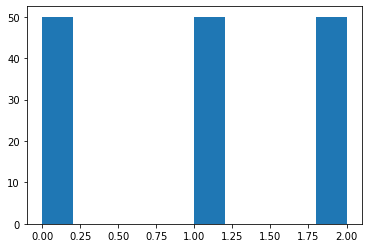

In [302]:
plt.hist(iris.target);
# Visualizing the distruibution of classes

<a id='iris_cvs_start'></a>

In [303]:
# Creation of groups for group based cross-validation
groups = np.full((1, 35), 0)
for i in range(1,3):
    group = np.full((1, 35), i)
    groups = np.concatenate((groups,group))
groups = groups.reshape((105))

In [304]:
from sklearn.model_selection import *
cvs = []
cvs.append(('K-fold', KFold(n_splits=5)))
cvs.append(('Repeated K-fold', RepeatedKFold(n_splits=5)))
cvs.append(('Leave one out', LeaveOneOut()))
cvs.append(('Leave p out', LeavePOut(p=2)))
cvs.append(('Shuffle split', ShuffleSplit(n_splits=5, test_size = 0.2)))
cvs.append(('Stratified K-fold', StratifiedKFold(n_splits=5)))
cvs.append(('Repeated Stratified K-fold', RepeatedStratifiedKFold(n_splits=5)))
cvs.append(('Stratified Shuffle Split', StratifiedShuffleSplit(n_splits=5)))
cvs.append(('Group K-fold', GroupKFold(n_splits=2)))
cvs.append(('Leave one group out', LeaveOneGroupOut()))
cvs.append(('Leave p groups out', LeavePGroupsOut(n_groups=2)))
cvs.append(('Group shuffle split', GroupShuffleSplit(n_splits=3)))
cvs.append(('Time Series Split', TimeSeriesSplit(n_splits=5)))

<a id='iris_cross_val_score'></a>

K-fold: 0.971429 (0.038095)
Repeated K-fold: 0.972381 (0.027089)
Leave one out: 0.971429 (0.166599)
Leave p out: 0.971429 (0.117235)
Shuffle split: 0.942857 (0.035635)
Stratified K-fold: 0.971429 (0.038095)
Repeated Stratified K-fold: 0.971429 (0.030117)
Stratified Shuffle Split: 0.981818 (0.036364)
Group K-fold: 0.971429 (0.000000)
Leave one group out: 0.971429 (0.023328)
Leave p groups out: 0.971429 (0.011664)
Group shuffle split: 0.952381 (0.013469)
Time Series Split: 0.964706 (0.047059)



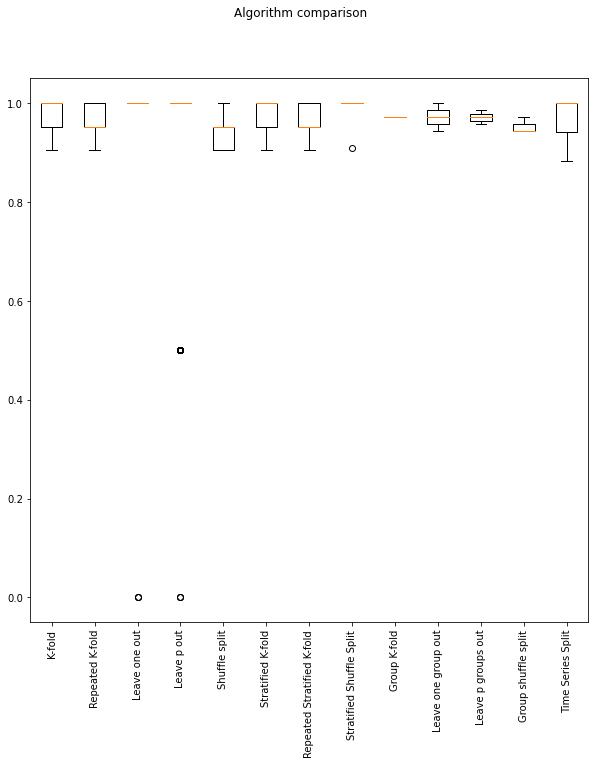

In [305]:
# In the last excersise LDA got the best results for the iris dataset.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()
df_iris = pd.DataFrame()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=50)
results = []
names = []
means = []
stds = []
for name, CV in cvs:
    cv_results = cross_val_score(model, X_train, y_train, cv=CV ,scoring='accuracy',n_jobs=-1, groups=groups)
    results.append(cv_results)
    names.append(name)
    means.append(cv_results.mean())
    stds.append(cv_results.std())
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
df_iris['Algorithm_name'] = names
df_iris['cross_val_score_mean'] = means
df_iris['cross_val_score_std'] = stds

numbers = np.linspace(1,len(cvs),len(cvs))
plt.figure(figsize=(10,10))
plt.suptitle('Algorithm comparison')
plt.boxplot(results)
plt.xticks(numbers,names,rotation=90)
print()

<a id='iris_cross_validate'></a>

K-fold: 0.971429 (0.038095)
Repeated K-fold: 0.972381 (0.031716)
Leave one out: 0.971429 (0.166599)
Leave p out: 0.971429 (0.117235)
Shuffle split: 0.980952 (0.023328)
Stratified K-fold: 0.971429 (0.038095)
Repeated Stratified K-fold: 0.971429 (0.030117)
Stratified Shuffle Split: 0.945455 (0.044536)
Group K-fold: 0.971429 (0.000000)
Leave one group out: 0.971429 (0.023328)
Leave p groups out: 0.971429 (0.011664)
Group shuffle split: 0.980952 (0.013469)
Time Series Split: 0.964706 (0.047059)



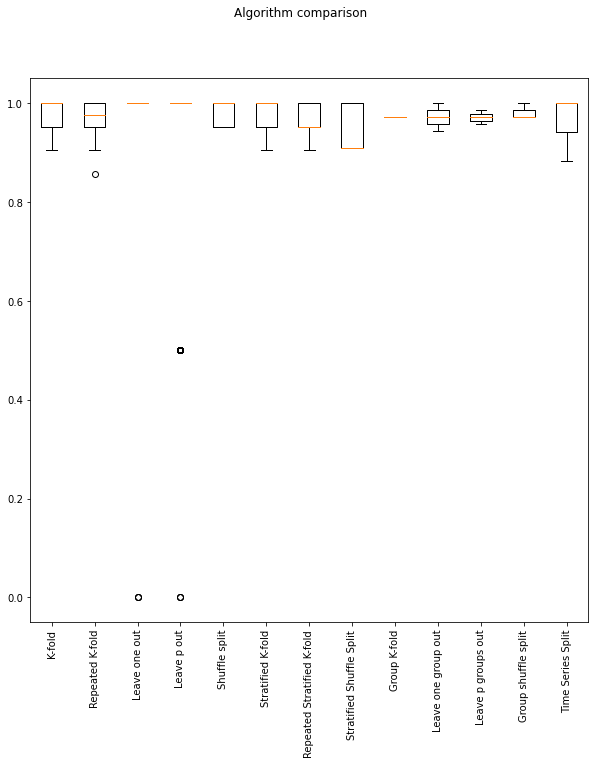

In [306]:
results = []
names = []
means = []
stds = []
for name, CV in cvs:
    cv_results = cross_validate(model, X_train, y_train, cv=CV ,scoring='accuracy',n_jobs=-1, groups=groups)
    results.append(cv_results['test_score'])
    names.append(name)
    means.append(cv_results['test_score'].mean())
    stds.append(cv_results['test_score'].std())
    msg = "%s: %f (%f)" % (name, cv_results['test_score'].mean(), cv_results['test_score'].std())
    print(msg)
    
df_iris['Algorithm_name'] = names
df_iris['cross_validate_mean'] = means
df_iris['cross_validate_std'] = stds

numbers = np.linspace(1,len(cvs),len(cvs))
plt.figure(figsize=(10,10))
plt.suptitle('Algorithm comparison')
plt.boxplot(results)
plt.xticks(numbers,names,rotation=90)
print()

<a id='iris_table'></a>

In [307]:
df_iris

,Algorithm_name,cross_val_score_mean,cross_val_score_std,cross_validate_mean,cross_validate_std
0,K-fold,0.971429,0.038095,0.971429,0.038095
1,Repeated K-fold,0.972381,0.027089,0.972381,0.031716
2,Leave one out,0.971429,0.166599,0.971429,0.166599
3,Leave p out,0.971429,0.117235,0.971429,0.117235
4,Shuffle split,0.942857,0.035635,0.980952,0.023328
5,Stratified K-fold,0.971429,0.038095,0.971429,0.038095
6,Repeated Stratified K-fold,0.971429,0.030117,0.971429,0.030117
7,Stratified Shuffle Split,0.981818,0.036364,0.945455,0.044536
8,Group K-fold,0.971429,0.000000,0.971429,0.000000
9,Leave one group out,0.971429,0.023328,0.971429,0.023328


<a id='pokemon_start'></a>

In [308]:
# Testing the same models for a different, less balanced dataset dataset
# Classification of pokemon types base on their statistics
pokemon_data = pd.read_csv('pokemon.csv')
pd.options.display.max_columns = None
pokemon_data.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,against_ground,against_ice,against_normal,against_poison,against_psychic,against_rock,against_steel,against_water,attack,base_egg_steps,base_happiness,base_total,capture_rate,classfication,defense,experience_growth,height_m,hp,japanese_name,name,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,49,5120,70,318,45,Seed Pokémon,49,1059860,0.7,45,Fushigidaneフシギダネ,Bulbasaur,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,62,5120,70,405,45,Seed Pokémon,63,1059860,1.0,60,Fushigisouフシギソウ,Ivysaur,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,100,5120,70,625,45,Seed Pokémon,123,1059860,2.0,80,Fushigibanaフシギバナ,Venusaur,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,52,5120,70,309,45,Lizard Pokémon,43,1059860,0.6,39,Hitokageヒトカゲ,Charmander,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,64,5120,70,405,45,Flame Pokémon,58,1059860,1.1,58,Lizardoリザード,Charmeleon,88.1,5,80,65,80,fire,NaN,19.0,1,0


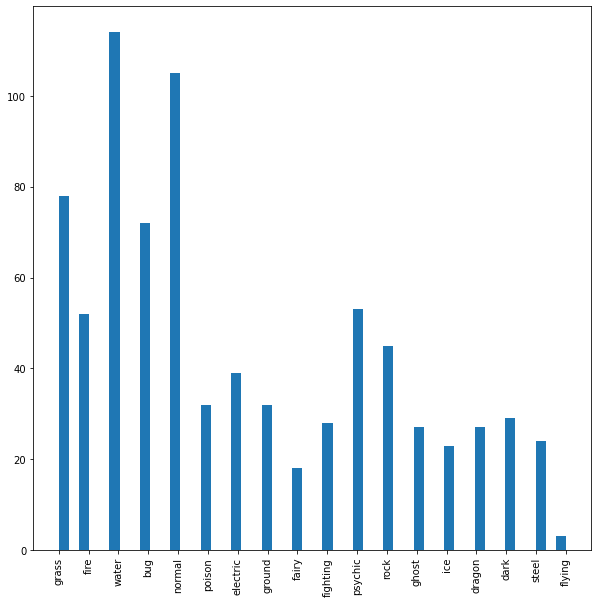

In [309]:
# Visualizing the target values distribution
plt.figure(figsize=(10,10))
plt.hist(pokemon_data['type1'],bins=50)
plt.xticks(pokemon_data['type1'].unique(),rotation=90);

In [310]:
pokemon_data.drop(['abilities','base_egg_steps','base_happiness','base_total','capture_rate','classfication',
                  'experience_growth','height_m','japanese_name','name','percentage_male','pokedex_number',
                  'type2','weight_kg','generation','is_legendary'], axis=1, inplace=True)
pokemon_data.head()

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,against_ground,against_ice,against_normal,against_poison,against_psychic,against_rock,against_steel,against_water,attack,defense,hp,sp_attack,sp_defense,speed,type1
0,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,49,49,45,65,65,45,grass
1,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,62,63,60,80,80,60,grass
2,1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,100,123,80,122,120,80,grass
3,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,52,43,39,60,50,65,fire
4,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,64,58,58,80,65,80,fire


In [311]:
# Creating seperate variable for target values
pokemon_data_y = pokemon_data.pop('type1')
pokemon_data_y.head()

0    grass
1    grass
2    grass
3     fire
4     fire
Name: type1, dtype: object

In [312]:
# Checking for NaN values
pokemon_data_y.isna().any()

False

In [313]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
pokemon_data_y = pd.DataFrame(le.fit_transform(pokemon_data_y),columns=['type'])
pokemon_data_y.head()

,type
0,9
1,9
2,9
3,6
4,6


In [314]:
# Dataset is ready, time to split the datastet and create new groups for group based cross-validation
X_train, X_test, y_train, y_test = train_test_split(pokemon_data, pokemon_data_y, test_size=0.3, random_state=50)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (560, 24)
X_test shape:  (241, 24)
y_train shape:  (560, 1)
y_test shape:  (241, 1)


<a id='pokemon_cvs_start'></a>

In [315]:
groups = np.full((1, 140), 0)
for i in range(1,4):
    group = np.full((1, 140), i)
    groups = np.concatenate((groups,group))
groups = groups.reshape((560))
cvs = []
cvs.append(('K-fold', KFold(n_splits=5)))
cvs.append(('Repeated K-fold', RepeatedKFold(n_splits=5)))
cvs.append(('Leave one out', LeaveOneOut()))
cvs.append(('Leave p out', LeavePOut(p=1))) # p lowered to make the code work faster
cvs.append(('Shuffle split', ShuffleSplit(n_splits=5, test_size = 0.2)))
cvs.append(('Stratified K-fold', StratifiedKFold(n_splits=5)))
cvs.append(('Repeated Stratified K-fold', RepeatedStratifiedKFold(n_splits=5)))
cvs.append(('Stratified Shuffle Split', StratifiedShuffleSplit(n_splits=5)))
cvs.append(('Group K-fold', GroupKFold(n_splits=2)))
cvs.append(('Leave one group out', LeaveOneGroupOut()))
cvs.append(('Leave p groups out', LeavePGroupsOut(n_groups=2)))
cvs.append(('Group shuffle split', GroupShuffleSplit(n_splits=3)))
cvs.append(('Time Series Split', TimeSeriesSplit(n_splits=5)))

<a id='pokemon_cross_val_score'></a>

K-fold: 0.828571 (0.049034)
Repeated K-fold: 0.843036 (0.032786)
Leave one out: 0.833929 (0.372145)
Leave p out: 0.833929 (0.372145)
Shuffle split: 0.855357 (0.038049)
Stratified K-fold: 0.839286 (0.032927)
Repeated Stratified K-fold: 0.844464 (0.029886)
Stratified Shuffle Split: 0.860714 (0.041342)

C:\Users\lukoz\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\lukoz\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\lukoz\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\lukoz\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\lukoz\anaconda3\lib\site-packages\s


Group K-fold: 0.837500 (0.019643)
Leave one group out: 0.835714 (0.038796)
Leave p groups out: 0.837500 (0.017344)
Group shuffle split: 0.876190 (0.023570)
Time Series Split: 0.840860 (0.061356)



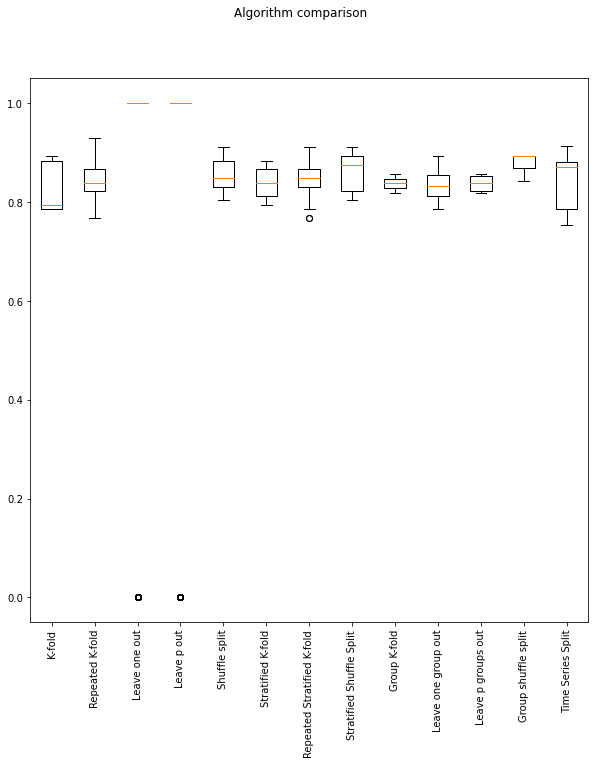

In [316]:
df_pokemon = pd.DataFrame()

results = []
names = []
means = []
stds = []
for name, CV in cvs:
    cv_results = cross_val_score(model, X_train, y_train, cv=CV ,scoring='accuracy',n_jobs=-1, groups=groups)
    results.append(cv_results)
    names.append(name)
    means.append(cv_results.mean())
    stds.append(cv_results.std())
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
df_pokemon['Algorithm_name'] = names
df_pokemon['cross_val_score_mean'] = means
df_pokemon['cross_val_score_std'] = stds

numbers = np.linspace(1,len(cvs),len(cvs))
plt.figure(figsize=(10,10))
plt.suptitle('Algorithm comparison')
plt.boxplot(results)
plt.xticks(numbers,names,rotation=90)
print()

<a id='pokemon_cross_validate'></a>

K-fold: 0.828571 (0.049034)
Repeated K-fold: 0.843750 (0.027851)
Leave one out: 0.833929 (0.372145)
Leave p out: 0.833929 (0.372145)
Shuffle split: 0.805357 (0.044963)
Stratified K-fold: 0.839286 (0.032927)
Repeated Stratified K-fold: 0.846964 (0.030981)

C:\Users\lukoz\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\lukoz\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\lukoz\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\lukoz\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\lukoz\anaconda3\lib\site-packages\s


Stratified Shuffle Split: 0.878571 (0.020825)
Group K-fold: 0.837500 (0.019643)
Leave one group out: 0.835714 (0.038796)
Leave p groups out: 0.837500 (0.017344)
Group shuffle split: 0.797619 (0.016836)
Time Series Split: 0.840860 (0.061356)



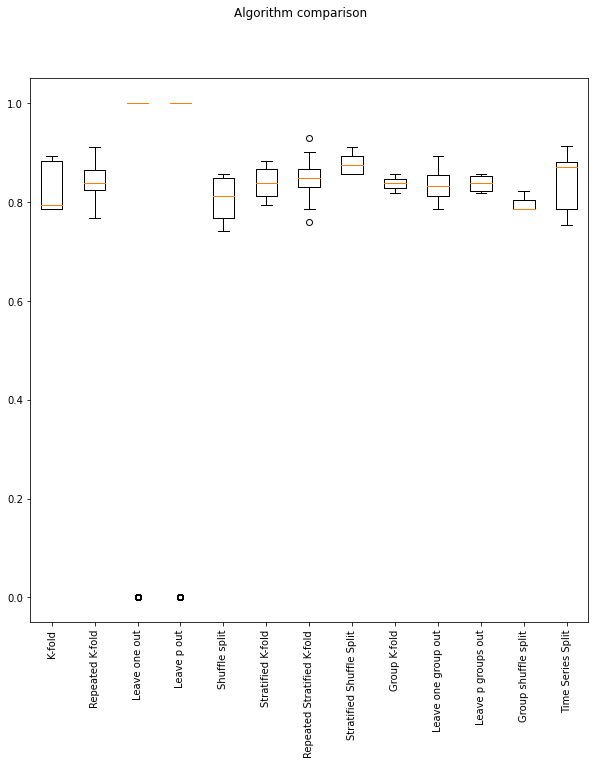

In [317]:
results = []
names = []
means = []
stds = []
for name, CV in cvs:
    cv_results = cross_validate(model, X_train, y_train, cv=CV ,scoring='accuracy',n_jobs=-1, groups=groups)
    results.append(cv_results['test_score'])
    names.append(name)
    means.append(cv_results['test_score'].mean())
    stds.append(cv_results['test_score'].std())
    msg = "%s: %f (%f)" % (name, cv_results['test_score'].mean(), cv_results['test_score'].std())
    print(msg)
    
df_pokemon['cross_validate_mean'] = means
df_pokemon['cross_validate_std'] = stds

numbers = np.linspace(1,len(cvs),len(cvs))
plt.figure(figsize=(10,10))
plt.suptitle('Algorithm comparison')
plt.boxplot(results)
plt.xticks(numbers,names,rotation=90)
print()

<a id='pokemon_table'></a>

In [318]:
df_pokemon

,Algorithm_name,cross_val_score_mean,cross_val_score_std,cross_validate_mean,cross_validate_std
0,K-fold,0.828571,0.049034,0.828571,0.049034
1,Repeated K-fold,0.843036,0.032786,0.843750,0.027851
2,Leave one out,0.833929,0.372145,0.833929,0.372145
3,Leave p out,0.833929,0.372145,0.833929,0.372145
4,Shuffle split,0.855357,0.038049,0.805357,0.044963
5,Stratified K-fold,0.839286,0.032927,0.839286,0.032927
6,Repeated Stratified K-fold,0.844464,0.029886,0.846964,0.030981
7,Stratified Shuffle Split,0.860714,0.041342,0.878571,0.020825
8,Group K-fold,0.837500,0.019643,0.837500,0.019643
9,Leave one group out,0.835714,0.038796,0.835714,0.038796


In [319]:
end = time.time()
print(end - start)

11.396941900253296


<a id='best_cell'></a>

In [320]:
# Displaying best algorithms for the iris dataset
df_iris.set_index('Algorithm_name', inplace=True)
maxValueIndex = df_iris[['cross_val_score_mean','cross_validate_mean']].idxmax() 
print(maxValueIndex)
minValueIndex = df_iris[['cross_val_score_std','cross_validate_std']].idxmin() 
print(minValueIndex)

cross_val_score_mean    Stratified Shuffle Split
cross_validate_mean                Shuffle split
dtype: object
cross_val_score_std    Group K-fold
cross_validate_std     Group K-fold
dtype: object


In [321]:
# Displaying best algorithms for the pokemon dataset
df_pokemon.set_index('Algorithm_name', inplace=True)
maxValueIndex = df_pokemon[['cross_val_score_mean','cross_validate_mean']].idxmax() 
print(maxValueIndex)
minValueIndex = df_pokemon[['cross_val_score_std','cross_validate_std']].idxmin() 
print(minValueIndex)

cross_val_score_mean         Group shuffle split
cross_validate_mean     Stratified Shuffle Split
dtype: object
cross_val_score_std     Leave p groups out
cross_validate_std     Group shuffle split
dtype: object
